# Load Packages

In [135]:
%load_ext lab_black
%load_ext autotime
%matplotlib inline
from IPython import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

pd.set_option("display.max_colwidth", 300)
pd.options.display.max_columns = None

from sklearn.preprocessing import StandardScaler
import pandas_profiling
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import itertools
import scipy
import matplotlib as mpl

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 36 ms


# Load data

In [2]:
df_order = pd.read_csv("audiences_orders_casestudy.csv")

time: 488 ms


In [3]:
df_basket = pd.read_csv("audiences_basket_casestudy.csv")

time: 2.87 s


In [52]:
df_order.head()

,order_date,order_number,order_sales,channel,store_banner,cx_id
0,2019-11-01,20191101|1001|1|1467,48.61,in-store,Loblaw,111311278077
1,2019-11-01,20191101|1010|56|1346,38.31,in-store,Loblaw,111247345357
2,2019-11-01,20191101|1040|9|5041,58.70,in-store,Loblaw,111347927977
3,2019-11-01,20191101|1099|1|3785,1.80,in-store,Loblaw,111142985927
4,2019-11-02,20191102|1004|23|9338,51.24,in-store,Loblaw,111277101457


time: 16 ms


In [117]:
df_online = df_order[df_order.channel == "online"]
df_in_store = df_order[df_order.channel == "in-store"]

time: 92 ms


# RFM clustering

## create RFM table

In [118]:
rfmTable = df_in_store.groupby("cx_id").agg(
    {
        "order_date": lambda x: (Day_baseline - x.max()).days,
        "order_number": lambda x: len(x),
        "order_sales": lambda x: x.sum(),
    }
)
rfmTable["order_date"] = rfmTable["order_date"].astype(int)
rfmTable.rename(
    columns={
        "order_date": "recency",
        "order_number": "frequency",
        "order_sales": "monetary_value",
    },
    inplace=True,
)
rfmTable.head()
rfmTable.info()

,recency,frequency,monetary_value
cx_id,,,
110000818067,3,30,1771.43
110002240717,2,48,3617.13
110004432917,1,20,1154.84
110005261047,3,49,1807.20
110005354477,3,6,491.09


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6985 entries, 110000818067 to 111495970257
Data columns (total 3 columns):
recency           6985 non-null int32
frequency         6985 non-null int64
monetary_value    6985 non-null float64
dtypes: float64(1), int32(1), int64(1)
memory usage: 191.0 KB
time: 1.7 s


## Normalize the Data

In [119]:
X = rfmTable.copy()
X.head()

,recency,frequency,monetary_value
cx_id,,,
110000818067,3,30,1771.43
110002240717,2,48,3617.13
110004432917,1,20,1154.84
110005261047,3,49,1807.20
110005354477,3,6,491.09


time: 8 ms


In [120]:
# X.monetary_value=np.log(X.monetary_value)
scaler = StandardScaler()
features = ["recency", "frequency", "monetary_value"]
X[features] = scaler.fit_transform(X[features])
X.head()

,recency,frequency,monetary_value
cx_id,,,
110000818067,0.269628,-0.358426,-0.157438
110002240717,0.071401,0.150368,0.665497
110004432917,-0.126825,-0.641089,-0.432354
110005261047,0.269628,0.178634,-0.141489
110005354477,0.269628,-1.036818,-0.728298


time: 20 ms


## Elbow Method to find the best cluster number

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'kmeans, Elbow Method')

Text(0.5, 0, 'Number of clusters, K')

Text(0, 0.5, 'Silhouette')

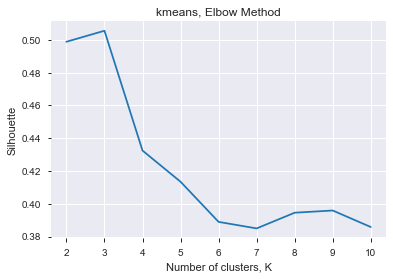

time: 13.1 s


In [139]:
silhouettes = {}
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k).fit(X)
    silhouettes[k] = silhouette_score(X, kmeans.labels_)

plt.figure()
plt.grid(True)
plt.plot(list(silhouettes.keys()), list(silhouettes.values()))
plt.title("kmeans, Elbow Method")
plt.xlabel("Number of clusters, K")
plt.ylabel("Silhouette")

## 3 is the best

In [175]:
kmeans = KMeans(n_clusters=3).fit(X)

time: 84 ms


In [178]:
kmeans.labels_

array([0, 2, 0, ..., 0, 0, 0])

time: 3.97 ms


In [179]:
X["label"] = kmeans.labels_
rfmTable["label"] = kmeans.labels_

time: 8 ms


In [181]:
rfmTable.loc[rfmTable["label"] == 0].describe()

,recency,frequency,monetary_value,label
count,5427.000000,5427.000000,5427.000000,5427.0
mean,1.454763,33.292980,1393.055228,0.0
std,1.169527,28.780248,1223.427470,0.0
min,0.000000,1.000000,-73.390000,0.0
25%,0.000000,14.000000,488.425000,0.0
50%,1.000000,28.000000,1078.040000,0.0
75%,2.000000,45.000000,1997.197500,0.0
max,12.000000,231.000000,9029.767000,0.0


time: 32 ms


In [182]:
rfmTable.loc[rfmTable["label"] == 1].describe()

,recency,frequency,monetary_value,label
count,552.000000,552.000000,552.000000,552.0
mean,1.155797,90.391304,4000.330551,1.0
std,1.037064,19.472232,3409.788807,0.0
min,0.000000,39.000000,449.098000,1.0
25%,0.000000,78.000000,1664.609250,1.0
50%,1.000000,90.000000,2383.928000,1.0
75%,2.000000,103.000000,7224.106250,1.0
max,3.000000,144.000000,14427.893000,1.0


time: 24 ms


In [183]:
rfmTable.loc[rfmTable["label"] == 2].describe()

,recency,frequency,monetary_value,label
count,1006.000000,1006.000000,1006.000000,1006.0
mean,2.903579,67.142147,5041.344796,2.0
std,12.922565,41.156160,2677.301870,0.0
min,0.000000,1.000000,5.930000,2.0
25%,1.000000,44.000000,4050.885000,2.0
50%,1.000000,59.000000,4641.625000,2.0
75%,2.000000,79.000000,5645.266500,2.0
max,281.000000,339.000000,64440.013000,2.0


time: 36 ms


In [187]:
rfmTable_online = df_online.groupby("cx_id").agg(
    {
        "order_date": lambda x: (Day_baseline - x.max()).days,
        "order_number": lambda x: len(x),
        "order_sales": lambda x: x.sum(),
    }
)
rfmTable_online["order_date"] = rfmTable_online["order_date"].astype(int)
rfmTable_online.rename(
    columns={
        "order_date": "recency",
        "order_number": "frequency",
        "order_sales": "monetary_value",
    },
    inplace=True,
)
rfmTable_online.describe()

,recency,frequency,monetary_value
count,248.000000,248.000000,248.000000
mean,53.560484,10.415323,1452.672371
std,77.253122,12.110193,2027.051263
min,0.000000,1.000000,23.110000
25%,2.000000,2.000000,180.495000
50%,14.000000,5.000000,563.599500
75%,83.750000,14.000000,1878.688750
max,302.000000,58.000000,11711.326000


time: 140 ms


# Compare online and offline RFM groups